In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np

import statsmodels.stats.api as sms
from manual_review_classifier.Analysis import calculate_kappa
from zero_one_based_conversion import convert

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_context('paper')

/Users/bainscou/anaconda/envs/manual_review/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
reviews = [[('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.bed.formated', False, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed.lmt.bed', True, 'H_KA-115225'), ('../data/reviewer_comparison/H_KA-115225/H_KA-115225_reviewed_Erica.txt', True, 'H_KA-115225')],
           [('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.bed.formated', False, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.lmt.bed', True, 'H_ML-08-0075-202'), ('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_Erica.txt', True, 'H_ML-08-0075-202') ],
           [('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.bed.formated', False, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed.lmt.bed', True, 'H_ND-006G'), ('../data/reviewer_comparison/H_ND-006G-C117D/H_ND-006G-C117D_reviewed_Erica.txt', True, 'H_ND-006G')],
           [('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed.bed.formated', False, 'H_SU-B12'), ('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed.lmt.bed', True, 'H_SU-B12'), ('../data/reviewer_comparison/H_SU-B12-17/H_SU-B12-17_reviewed_Erica.txt', True, 'H_SU-B12')]]


In [4]:
r = pd.read_csv('../data/reviewer_comparison/H_ML-08-0075-202-1121768/H_ML-08-0075-202-1121768_reviewed.bed.formated', sep='\t', names=['Chromosome', 'Start', 'Stop', 'Reference', 'Variant', 'Call', 'Tags', 'Notes'])

In [5]:
def get_review_df(filepath, header, individual_name):
    if header:
        review = pd.read_csv(filepath, sep='\t')
    else:
        col_names = ['Chromosome', 'Start', 'Stop', 'Reference', 'Variant', 
                     'Call', 'Tags', 'Notes']
        review = pd.read_csv(filepath, sep='\t', names=col_names)
    review.drop(['Tags', 'Notes'], inplace=True, axis=1)
    #verify below mapping with preprocessing
    review.replace({'Call': {'O':'F', 'V':'G', 'LOH': 'S', 'LQ': 'F'}}, 
                    inplace=True)
    review.sort_values(['Chromosome', 'Start', 'Stop',
                        'Reference', 'Variant'])
    review.index = individual_name + '~' + review.Chromosome.map(str) +':'+ \
                    review.Start.map(str) + '-' + review.Stop.map(str) + \
                    review.Reference + '>' + review.Variant
    return review.drop_duplicates(subset=['Chromosome', 'Start', 'Stop', 
                                          'Reference', 'Variant'])

In [6]:
def get_kappa_counts(calls):
    kappa_list = []
    index_list = []
    for name, group in calls.groupby(['Chromosome', 'Start', 'Stop', 
                                      'Reference', 'Variant']):
        A=F=G=S=0 
        for call in group.Call.iteritems():
            if call[1] == 'A':
                A+=1
            elif call[1] == 'F':
                F+=1
            elif call[1] == 'G':
                G+=1
            elif call[1] == 'S':
                S+=1
        if A+F+G+S != 3:
            raise ValueError('{0}: {1}'.format(name, group))
        kappa_list.append([A, F, G, S])
        index_list.append(group.index[0])
    return np.array(kappa_list), index_list

In [7]:
calls = pd.DataFrame()
kappa_table = np.array([]).reshape(0,4)
idx = []
for sample in reviews:
    calls = pd.concat([get_review_df(r[0], r[1], r[2]) for r in sample])
    kappa_list, index_list = get_kappa_counts(calls)
    kappa_table = np.concatenate([kappa_table, kappa_list])
    idx = idx + index_list

In [8]:
kappa_table.shape

(176, 4)

In [9]:
def calculate_kappa(table):
    """https://en.wikipedia.org/wiki/Fleiss%27_kappa"""
    N, k = table.shape

    n = table.sum(axis=1)[0]

    p = table.sum(axis=0)/ (N * n)

    P = (1/(n*(n-1)))*((table**2).sum(axis=1) - n)

    p_bar = P.sum()/N

    P_e = (p**2).sum()

    kappa = (p_bar - P_e)/ (1 - P_e)
    
    return kappa

## Interpreting Fleiss's kappa

| 𝛋        | Interpretation           |
| :-------------: |-------------:|
| < 0      | Poor agreement |
| 0.01 – 0.20      | Slight agreement      |
| 0.21 – 0.40 | Fair agreement      |
| 0.41 – 0.60 | Moderate agreement      |
| 0.61 – 0.80 | Substantial agreement      |
| 0.81 – 1.00 | Almost perfect agreement      |

In [10]:
print('Fleiss\'s kappa statistic for all calls is {0}'.format(calculate_kappa(kappa_table)))

Fleiss's kappa statistic for all calls is 0.3091525278308058


In [11]:
somatic_fail_kappa_table = np.concatenate((kappa_table[:,:3].sum(axis=1).reshape((176,1)), 
                                           kappa_table[:,3:]), axis=1)

In [12]:
print('Fleiss\'s kappa statistic for somatic vs fail is {0}'.format(calculate_kappa(somatic_fail_kappa_table)))

Fleiss's kappa statistic for somatic vs fail is 0.415043207035844


In [13]:
# collapse germline and fail calls since germline is a specific type of fail
kappa_table_no_g = np.concatenate([kappa_table[:,0:1] ,kappa_table[:,1:2]+kappa_table[:,2:3], kappa_table[:,3:]], axis = 1)

In [14]:
print('Fleiss\'s kappa statistic for collapsed germline calls is {0}'.format(calculate_kappa(kappa_table_no_g)))

Fleiss's kappa statistic for collapsed germline calls is 0.3743362271085481


## Plot reviewer aggreement

In [15]:
model_output = pd.read_pickle('../data/xval_model_results_f.pkl')

In [16]:
model_output['individual_name'] = model_output.index.str.extract('(.*)~', expand=False)
model_output['chr'] = model_output.index.str.extract('~(.*):', expand=False)
model_output['start'] = model_output.index.str.extract(':(.*)-\d+[A-z-]+>', expand=False)
model_output['stop'] = model_output.index.str.extract('\d+-(\d*)[A-z-]+>', expand=False)
model_output['ref'] = model_output.index.str.extract('-\d+([A-z-]+)>', expand=False)
model_output['var'] = model_output.index.str.extract('>([A-z-]+)', expand=False)

In [17]:
kappa_idx = pd.DataFrame(idx)

In [18]:
kappa_idx['chr'] = kappa_idx[0].str.extract('~(.*):', expand=False)
kappa_idx['start'] = kappa_idx[0].str.extract(':(.*)-\d+[A-z-]>', expand=False)
kappa_idx['stop'] = kappa_idx[0].str.extract('\d+-(\d*)[A-z-]>', expand=False)
kappa_idx['ref'] = kappa_idx[0].str.extract('-\d+([A-z-]+)>', expand=False)
kappa_idx['var'] = kappa_idx[0].str.extract('>([A-z-]+)', expand=False)
kappa_idx['individual_name'] = kappa_idx[0].str.extract('(.*)~', expand=False)
del kappa_idx[0]

In [19]:
def convert_one_based(row):
    return convert.coordinate_system('\t'.join(map(str,row.values)), 'to_one_based').strip().split('\t')

In [20]:
kappa_idx= kappa_idx.apply(convert_one_based, axis=1)

Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 10	112338376	112338378	G	nan	H_ML-08-0075-202
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 12	49445267	49445269	G	nan	H_ML-08-0075-202
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 14	nan	nan	CATAGATTTGCTCACTGAC	nan	H_ML-08-0075-202
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 14	nan	nan	TCC	nan	H_ML-08-0075-202
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 15	nan	nan	TGGAGC	nan	H_ML-08-0075-202
Coordinate Error in line 1 or input. Coordinate skipped.
	Message: Invalid format, expected chr, start, stop, ref, var. Line: 19	nan	nan	GGGGGAT	nan	H_ML

In [21]:
somatic_model_out = pd.merge(kappa_idx, model_output, on=['chr','start','stop','ref','var','individual_name'], how='left').Somatic.values

In [22]:
# count the different combinations of calls
sss = ssa = saa = ssf = sff = saf = aaa = aaf = aff = fff = 0
sss_mo, ssa_mo, saa_mo, ssf_mo, sff_mo, saf_mo, aaa_mo, aaf_mo, aff_mo, fff_mo = ([] for i in range(10))
for i in range(len(kappa_table_no_g)):
    if kappa_table_no_g[i][0]==3:
        aaa += 1
        aaa_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][1]==3:
        fff += 1
        fff_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][2]==3:
        sss += 1
        sss_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][0] == 1 and kappa_table_no_g[i][2]==2:
        ssa += 1
        ssa_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][0]==2 and kappa_table_no_g[i][2]==1:
        saa += 1
        saa_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][1]==1 and kappa_table_no_g[i][2]==2:
        ssf += 1
        ssf_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][1]==2 and kappa_table_no_g[i][2]==1:
        sff += 1
        sff_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][0]==1 and kappa_table_no_g[i][1]==1 and kappa_table_no_g[i][2]==1:
        saf += 1
        saf_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][0]==2 and kappa_table_no_g[i][1]==1:
        aaf += 1
        aaf_mo.append(somatic_model_out[i])
    elif kappa_table_no_g[i][0]==1 and kappa_table_no_g[i][1]==2:
        aff += 1
        aff_mo.append(somatic_model_out[i])

In [23]:
def get_mean(output_list):
    return np.array([x for x in output_list if str(x) != 'nan']).mean()

In [24]:
def get_mean_ci(output_list):
    ci = sms.DescrStatsW([x for x in output_list if str(x) != 'nan']).tconfint_mean()
    return (ci[1]-ci[0])/2

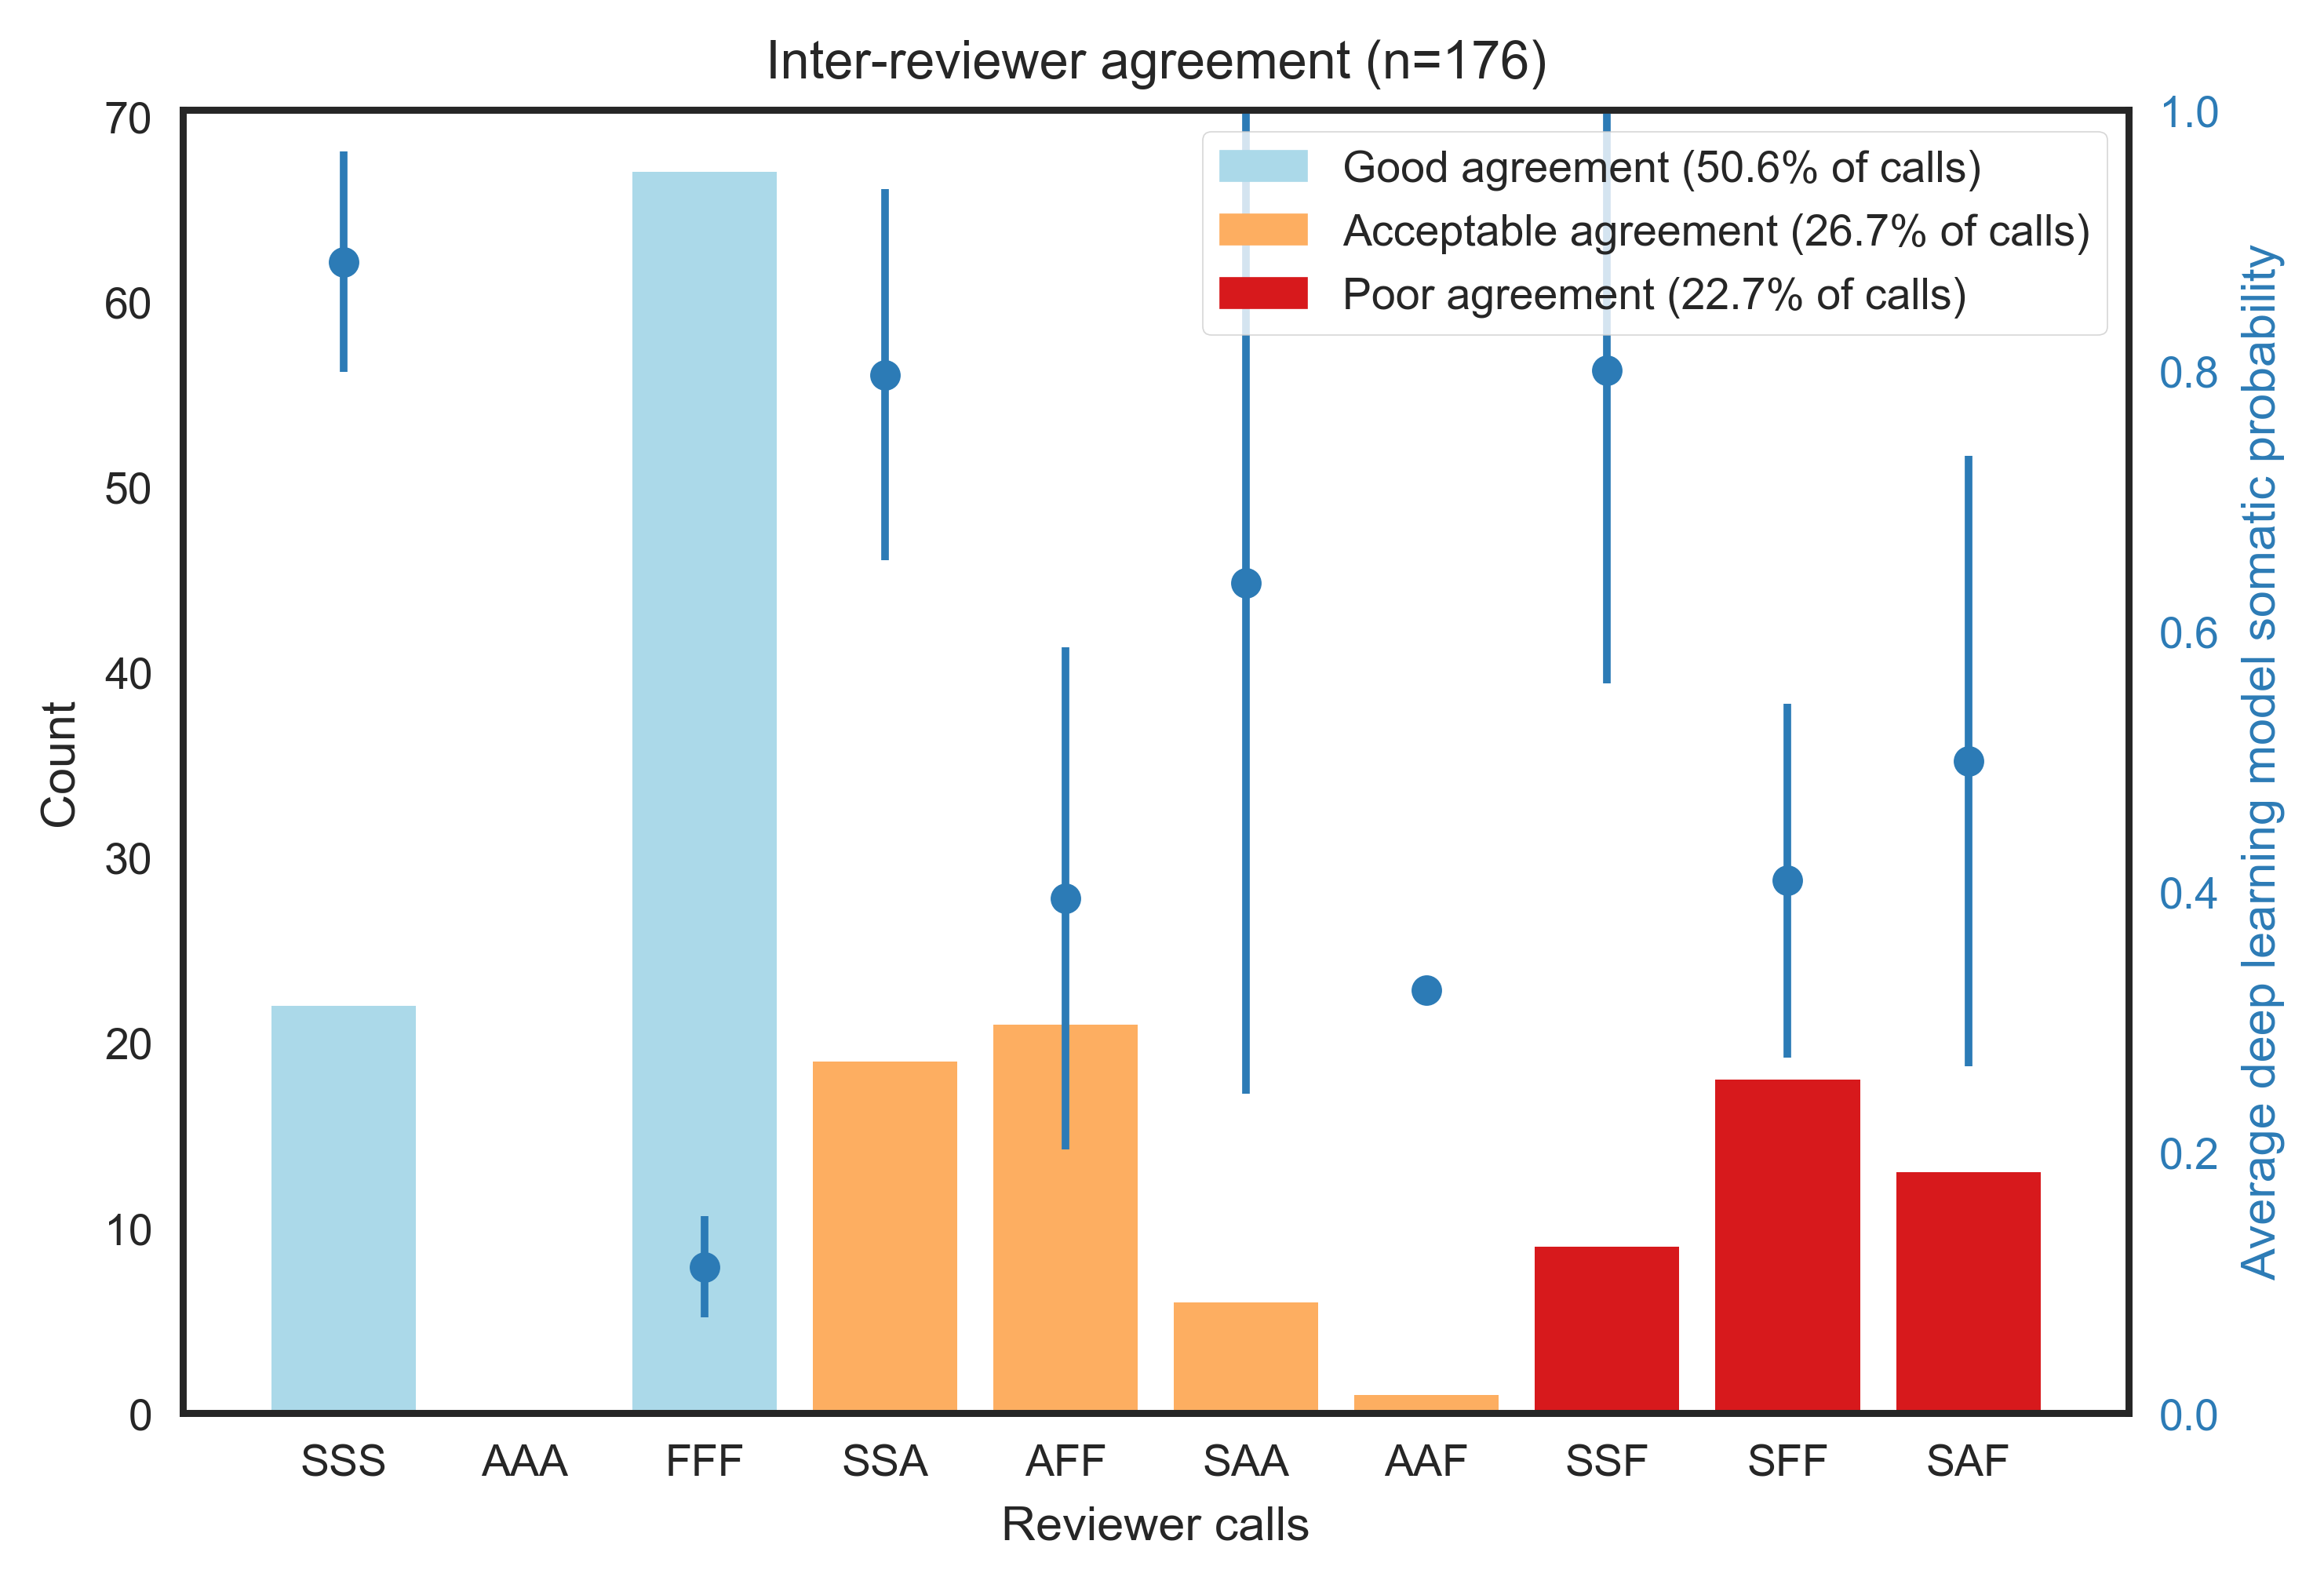

In [29]:
tot = sss + aaa + fff + ssa + aff + saa + aaf + ssf + sff + saf
y_pos = np.arange(10)

fig, ax1 = plt.subplots(dpi=500)
ax1.bar(y_pos, [sss, aaa, fff, ssa, aff, saa, aaf, ssf, sff, saf], 
        color=['#abd9e9', '#abd9e9', '#abd9e9', '#fdae61', '#fdae61', '#fdae61', '#fdae61', '#d7191c', '#d7191c', '#d7191c'])
labels = ['SSS', 'AAA', 'FFF', 'SSA', 'AFF', 'SAA', 'AAF', 'SSF', 'SFF', 'SAF']
plt.xticks(y_pos, labels)

ax2 = ax1.twinx()
ax2.errorbar([0, 2, 3, 4, 5, 6, 7, 8, 9], [get_mean(sss_mo), get_mean(fff_mo), get_mean(ssa_mo), 
                     get_mean(aff_mo), get_mean(saa_mo), get_mean(aaf_mo), 
                     get_mean(ssf_mo), get_mean(sff_mo), get_mean(saf_mo)],
             yerr=[get_mean_ci(sss_mo), get_mean_ci(fff_mo), get_mean_ci(ssa_mo), 
                     get_mean_ci(aff_mo), get_mean_ci(saa_mo), 0, 
                     get_mean_ci(ssf_mo), get_mean_ci(sff_mo), get_mean_ci(saf_mo)],
             fmt='o', c='#2c7bb6')
ax2.set_ylim([0,1])

good = mpatches.Patch(color='#abd9e9', label='Good agreement ({0:.1f}% of calls)'.format((sss+aaa+fff)/tot*100))
acceptable = mpatches.Patch(color='#fdae61', label='Acceptable agreement ({0:.1f}% of calls)'.format((ssa+aff+saa+aaf)/tot*100))
poor = mpatches.Patch(color='#d7191c', label='Poor agreement ({0:.1f}% of calls)'.format((ssf+sff+saf)/tot*100))
plt.legend(handles=[good, acceptable, poor],frameon=True)
ax1.set_ylabel('Count')
ax1.set_xlabel('Reviewer calls')
ax2.set_ylabel('Average deep learning model somatic probability', color='#2c7bb6')
ax2.tick_params(axis='y', labelcolor='#2c7bb6')
plt.title('Inter-reviewer agreement (n={0})'.format(tot))
plt.show()

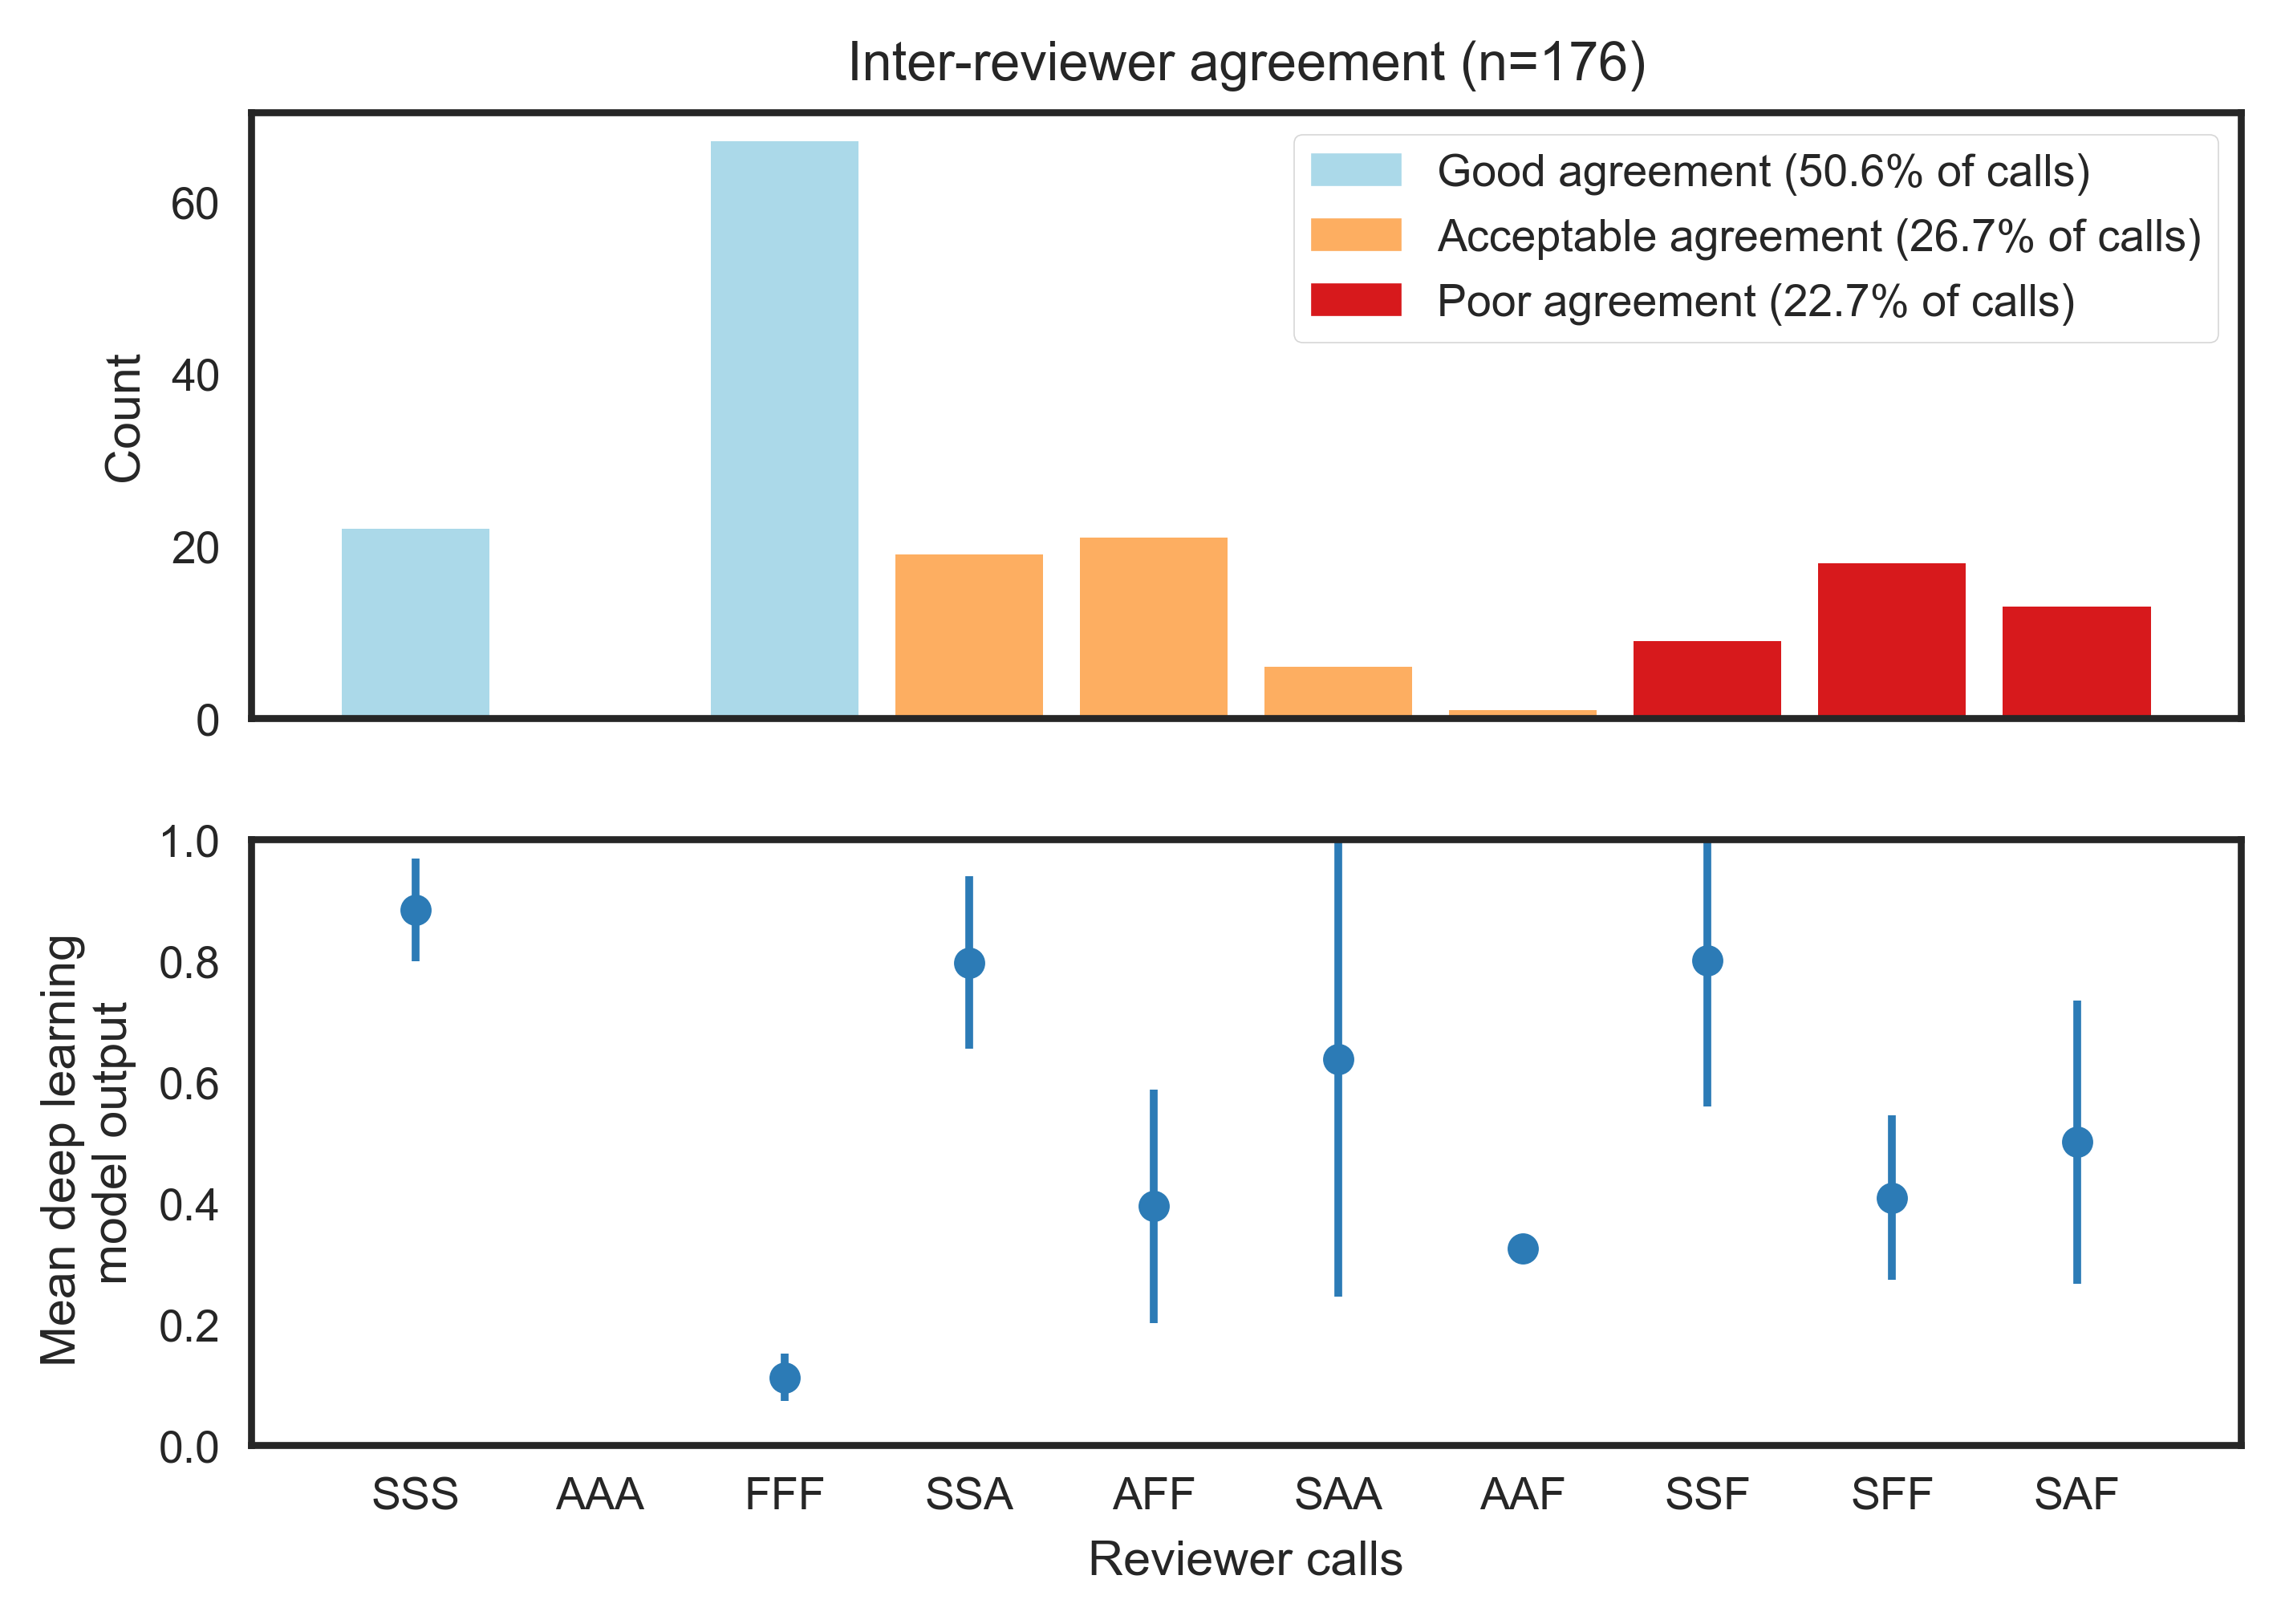

In [30]:

y_pos = np.arange(10)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, dpi=500)
ax1.bar(y_pos, [sss, aaa, fff, ssa, aff, saa, aaf, ssf, sff, saf], 
        color=['#abd9e9', '#abd9e9', '#abd9e9', '#fdae61', '#fdae61', '#fdae61', '#fdae61', '#d7191c', '#d7191c', '#d7191c'])
labels = ['SSS', 'AAA', 'FFF', 'SSA', 'AFF', 'SAA', 'AAF', 'SSF', 'SFF', 'SAF']
plt.xticks(y_pos, labels)


ax2.errorbar([0, 2, 3, 4, 5, 6, 7, 8, 9], [get_mean(sss_mo), get_mean(fff_mo), get_mean(ssa_mo), 
                     get_mean(aff_mo), get_mean(saa_mo), get_mean(aaf_mo), 
                     get_mean(ssf_mo), get_mean(sff_mo), get_mean(saf_mo)],
             yerr=[get_mean_ci(sss_mo), get_mean_ci(fff_mo), get_mean_ci(ssa_mo), 
                     get_mean_ci(aff_mo), get_mean_ci(saa_mo), 0, 
                     get_mean_ci(ssf_mo), get_mean_ci(sff_mo), get_mean_ci(saf_mo)],
             fmt='o', c='#2c7bb6')
ax2.set_ylim([0,1])

good = mpatches.Patch(color='#abd9e9', label='Good agreement ({0:.1f}% of calls)'.format((sss+aaa+fff)/tot*100))
acceptable = mpatches.Patch(color='#fdae61', label='Acceptable agreement ({0:.1f}% of calls)'.format((ssa+aff+saa+aaf)/tot*100))
poor = mpatches.Patch(color='#d7191c', label='Poor agreement ({0:.1f}% of calls)'.format((ssf+sff+saf)/tot*100))
ax1.legend(handles=[good, acceptable, poor],frameon=True)
ax1.set_ylabel('Count')
ax2.set_xlabel('Reviewer calls')
ax2.set_ylabel('Mean deep learning \nmodel output')
ax2.tick_params(axis='y')
ax1.set_title('Inter-reviewer agreement (n={0})'.format(tot))
fig.savefig('../figures/reviewer_agreement.png')
fig.savefig('../figures/reviewer_agreement.pdf')
plt.show()